Ce code est tiré de ce très bon article de Purva Huilgol :

https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [1]:
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

--2023-01-12 11:01:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.163.128, 142.251.16.128, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.163.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   213MB/s    in 0.3s    

2023-01-12 11:01:24 (213 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [3]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

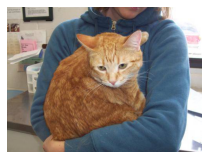

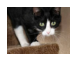

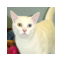

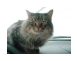

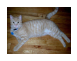

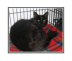

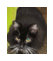

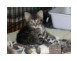

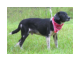

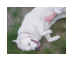

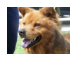

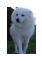

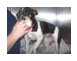

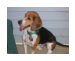

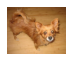

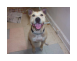

In [4]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
next_cat_pix = [os.path.join(train_cats_dir, fname) 
for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
# Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.show() 

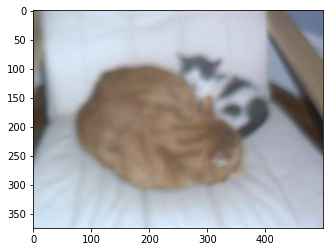

In [5]:
my_img = mpimg.imread("/tmp/cats_and_dogs_filtered/train/cats/cat.241.jpg")
plt.imshow(my_img)
plt.show() 

In [6]:
# data augmentation

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [7]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))
# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Note : 1792 correspond bien à un kernel de 3.3.3 (puisque trois canaux) + 1 pour le biais, le tout multiplié par le nombre de canaux de sorties = différents filtres appris. Soit la formule : 64.(3.3.3 + 1) = 1792

In [12]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 43s 337ms/step - loss: 0.6994 - acc: 0.6735 - val_loss: 0.5625 - val_acc: 0.7050
Epoch 2/10
100/100 [==============================] - 34s 338ms/step - loss: 0.4938 - acc: 0.7620 - val_loss: 0.2578 - val_acc: 0.8880
Epoch 3/10
100/100 [==============================] - 34s 337ms/step - loss: 0.4275 - acc: 0.7895 - val_loss: 0.2233 - val_acc: 0.9120
Epoch 4/10
100/100 [==============================] - 34s 335ms/step - loss: 0.4028 - acc: 0.8115 - val_loss: 0.2251 - val_acc: 0.9050
Epoch 5/10
100/100 [==============================] - 34s 335ms/step - loss: 0.3730 - acc: 0.8335 - val_loss: 0.2091 - val_acc: 0.9160
Epoch 6/10
100/100 [==============================] - 34s 337ms/step - loss: 0.3549 - acc: 0.8375 - val_loss: 0.2028 - val_acc: 0.9200
Epoch 7/10
100/100 [==============================] - 35s 345ms/step - loss: 0.3423 - acc: 0.8435 - val_loss: 0.2171 - val_acc: 0.9050
Epoch 8/10
100/100 [==============================] - 3

In [13]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
test_cats = test_datagen.flow_from_directory("/content/drive/My Drive/data/animals/cats",  batch_size = 1, shuffle = False, class_mode = 'binary', target_size = (224, 224))
model.predict(test_cats)

Found 2 images belonging to 1 classes.
2/2 [==============================] - 1s 9ms/step


array([[7.8327044e-05],
       [7.9713259e-03]], dtype=float32)

In [15]:
test_dogs = test_datagen.flow_from_directory("/content/drive/My Drive/data/animals/dogs",  batch_size = 1, shuffle = False, class_mode = 'binary', target_size = (224, 224))
model.predict(test_dogs)

Found 2 images belonging to 1 classes.
2/2 [==============================] - 0s 244ms/step


array([[0.9893882 ],
       [0.11365286]], dtype=float32)

In [16]:
train_generator.class_indices
# le classifieur a appris à reconnaître les chiens (1) vs. les chats (0)

{'cats': 0, 'dogs': 1}

In [17]:
# et la vache ?
test_others = test_datagen.flow_from_directory("/content/drive/My Drive/data/animals/others",  batch_size = 1, shuffle = False, class_mode = 'binary', target_size = (224, 224))
model.predict(test_others)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 34ms/step


array([[0.9942062]], dtype=float32)